1. Load real data
2. Get dict for every sample and protein with peptide:abundance
3. Compute disassembly, save in dict ```results[sample][protein]```

In [1]:
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/ErikHartman/pepnets/main/data/data.csv")
design = pd.read_csv("https://raw.githubusercontent.com/ErikHartman/pepnets/main/data/design.csv")
proteome = pd.read_csv("https://raw.githubusercontent.com/ErikHartman/pepnets/main/data/sus_scrofa.gz", sep="\t")
data.head()

,Protein,Peptide,Start,End,Mods,Sample 17 Day 1,Sample 18 Day 1,Sample 19 Day 1,Sample 20 Day 1,Sample 21 Day 1,...,Sample 57 Day 3,Sample 6 Day 1,Sample 7 Day 1,Sample 8 Day 1,Sample 9 Day 1,Sample 6 Day 2,Sample 7 Day 2,Sample 8 Day 2,Sample 9 Day 2,id
0,F1RX36,EVQDKGEFLAEGGGV,48,62,|,19.027615,19.382448,19.961013,21.187212,21.368261,...,21.033294,21.174478,20.748411,20.302304,19.214573,21.597742,20.836507,20.925307,18.585502,0
1,F1RX36,TQARETPPEWKALLETRQV,267,285,|,9.865061,8.239543,NaN,10.576868,11.717915,...,15.099619,14.430800,12.746662,13.029899,13.513466,15.524457,13.921798,13.648346,NaN,1
2,F1RX36,AEVQDKGEFLAEGGGV,47,62,|,17.218737,17.385290,17.685324,18.457380,18.683422,...,17.975231,18.464215,18.031206,15.622869,14.767041,16.725992,16.181084,17.384373,14.583107,2
3,F1RX36,VQDKGEFLAEGGGV,49,62,|,18.036758,18.311151,18.354891,17.804428,19.686764,...,19.138828,18.747020,18.025790,15.337530,13.093820,18.733983,17.971121,18.258311,15.906347,3
4,F1RX36,EVQDKGEFLAEGGGVR,48,63,|,19.610232,18.691592,19.474747,20.322715,19.572983,...,20.906823,20.271821,19.153869,20.270388,19.101946,18.723957,20.401157,17.591283,16.817444,4


In [2]:
proteome.head()

,Entry,Entry Name,Sequence
0,A0A0B5CYA5,A0A0B5CYA5_PIG,MNLWELEDHKSCRETPRPAQEPTAEEVMTTELQMKVDFFRKLGYSS...
1,A0A0N4SWI8,A0A0N4SWI8_PIG,MDESALTLGTIDVSYLPNSSEYSIGRCKHASEEWGECGFRPPVFRS...
2,A0A140TAK4,A0A140TAK4_PIG,MGRRKHRPTRRLDSAEAPRRPAMAEGGSGAESAPPTPSMSSLPLAA...
3,A0A1S6M251,B4GT5_PIG,MRVRRGLLRLPRRSLLAALFFFSLSSSLLYFVYVAPGIVNTYLFMM...
4,A0A286ZIP0,A0A286ZIP0_PIG,MCNTNMSVSTDGAVSTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...


In [3]:
# Prepares data
samples = design["sample"]
data_dict = {}
for sample in samples[0:10]:
    sample_data = data[["Protein", "Peptide", sample]].dropna(subset=[sample])
    protein_dict = {}
    for protein in sample_data["Protein"].unique():
        protein_data = sample_data[sample_data["Protein"] == protein]
        peptide_dict = {}
        # insert the original protein sequence
        protein_sequence = proteome[proteome["Entry Name"].isin([f"{protein}_PIG", protein])]["Sequence"].values[0]
        peptide_dict[protein_sequence] = 10 # probably want to replace this with some reasonable number
        if len(protein_data.index) > 10: # minimum number of unique peptides
            for i, row in protein_data.iterrows():
                peptide = row["Peptide"]
                abundance = row[sample]
                peptide_dict[peptide] = abundance
            protein_dict[protein] = peptide_dict
    data_dict[sample] = protein_dict
data_dict.keys()

dict_keys(['Sample 1 Day 1', 'Sample 2 Day 1', 'Sample 3 Day 1', 'Sample 4 Day 1', 'Sample 5 Day 1', 'Sample 10 Day 1', 'Sample 11 Day 1', 'Sample 12 Day 1', 'Sample 13 Day 1', 'Sample 14 Day 1'])

In [4]:
from disassembly.estimate_weights import estimate_weights
from disassembly.disassembly import get_disassembly_indexes_mc, get_disassembly

results = {} # dict of sample: protein_disassembly


for sample, protein_dict in data_dict.items():
    print(f"\n ---{sample}--- \n")
    protein_disassembly = {} # dict of protein: disassembly
    for protein, peptidome in protein_dict.items():
        graph, _, _,_ = estimate_weights(peptidome, lr=10, n_iterations=500, early_stop=False)
        di = get_disassembly_indexes_mc(graph, N_particles = 10000)
        disassembly = get_disassembly(peptidome, di)
        protein_disassembly[protein] = disassembly
    results[sample] = protein_disassembly


 ---Sample 1 Day 1--- 

 13 / 500 | 5.81, mean: 4.91 | Increasing | nz: 1434

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 99 / 500 | 6.87, mean: 6.88 | Increasing | nz: 1405
Learning rate decreased to 5.0
 174 / 500 | 7.08, mean: 7.13 | Increasing | nz: 1395
Learning rate decreased to 2.5
 249 / 500 | 7.43, mean: 7.28 | Plateau | nz: 1349376
Learning rate decreased to 1.25
 324 / 500 | 3.52, mean: 3.51 | Increasing | nz: 1003
Learning rate decreased to 0.625
 399 / 500 | 3.53, mean: 3.53 | Plateau | nz: 1001003
Learning rate decreased to 0.3125
 474 / 500 | 3.53, mean: 3.53 | Plateau | nz: 1000
Learning rate decreased to 0.15625
 499 / 500 | 3.53, mean: 3.53 | Plateau | nz: 1000
 Averaged DI: 1.75
 99 / 500 | 2.87, mean: 2.98 | Increasing | nz: 529
Learning rate decreased to 5.0
 174 / 500 | 3.03, mean: 2.79 | Plateau | nz: 571517
Learning rate decreased to 2.5
 249 / 500 | 2.19, mean: 2.24 | Increasing | nz: 525
Learning rate decreased to 1.25
 324 / 500 | 0.11, mean: 0.12 | Plateau | nz: 760700
Learning rate decreased to 0.625
 399 / 500 | 0.00, mean: 0.00 | Plateau | nz: 796796
Learning rate decreased

In [5]:
results_df = pd.DataFrame(results)

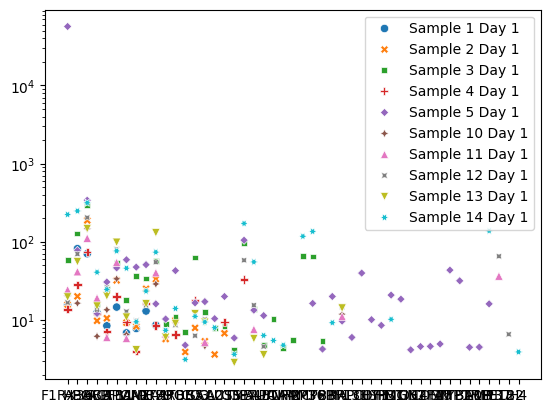

In [19]:
import seaborn as sns
sns.scatterplot(results_df)
import matplotlib.pyplot as plt
plt.yscale("log")

<Axes: >

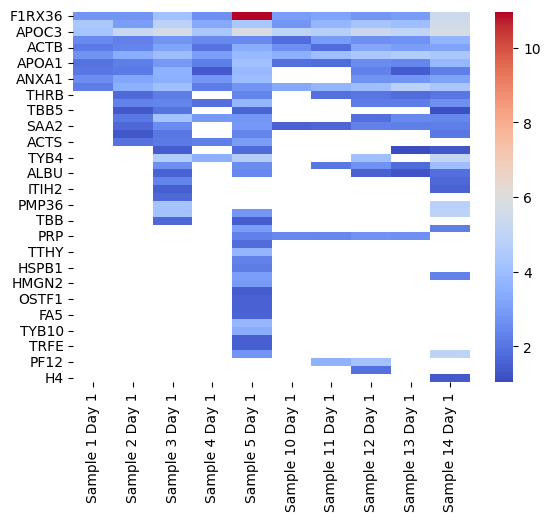

In [21]:
import seaborn as sns
import numpy as np

sns.heatmap(results_df.apply(np.log), cmap="coolwarm")